In [11]:
import gymnasium as gym
import numpy as np
import torch
import random

gym.__version__

'0.29.0'

For reproducibility and testing, we'll need to set all this seed stuff.

In [22]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator().manual_seed(SEED)

In [13]:
env = gym.make("LunarLander-v2")

From [docs](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

## Action Space
There are four discrete actions available:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine


In [14]:
env.action_space

Discrete(4)


## Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.


In [15]:
print(env.observation_space.shape)
env.observation_space

(8,)


Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

## Rewards
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

## Taking a step

In [16]:
env.reset(seed=SEED)
observation, reward, terminated, truncated, info = env.step(0)
reward

1.1449811454510836

## Reinforcement Learning Objective

Our performance measure: 

$$
J(\theta) = \mathbb{E} \left[ \sum_{t=0}^{T-1}r_{t+1} \right]
$$

and our update rule:

$$
\theta \leftarrow \theta + \frac{\partial}{\partial \theta} J(\theta)
$$

The gradient
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a q_\pi(S_t, a) \nabla \pi (a | S_t, \theta) \right]
$$
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \frac{\nabla \pi (a | S_t, \theta)}{\pi (a | S_t, \theta)} \right]
$$

If we sample $A_t \sim \pi$, then we just replace the expectation over $a$ with the sample $A_t$. So we're doing this swap from expectation to sample:
$$
\sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \rightarrow q_\pi(S_t, A_t)
$$
which then simplifies $\nabla J(\theta)$ to

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ q_\pi(S_t, A_t) \frac{\nabla \pi (A_t | S_t, \theta)}{\pi (A_t | S_t, \theta)} \right]
$$

and by $\mathbb{E}_\pi [G_t | S_t, A_t] = q_\pi (S_t, A_t)$, (add note to explain how we get G_t)

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \frac{\nabla \pi (A_t | S_t, \theta)}{\pi (A_t | S_t, \theta)} \right]
$$

We're going to make one more simplification: note that $\nabla \ln x = \frac{\nabla x}{x}$, so
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \nabla \ln \pi (A_t | S_t, \theta) \right]
$$

Now, we can actually calculate the value in brackets at each time step, and can then use it to update $\theta$:

$$
\theta_{t+1} = \theta_t + \alpha G_t \nabla \ln \pi(A_t | S_t, \theta_t)
$$

We're now going to generate an episode $S_0, A_0, R_1,...,S_{T-1}, A_{T-1}, R_T$.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize policy network
# takes in a state, determines the next action
class PolicyNetwork(nn.Module):
    def __init__(self, obs_size, action_size, seed=None):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(obs_size, action_size, bias=False),
            nn.ReLU()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        logits = self.layer(x)
        return torch.log(F.softmax(logits, dim=-1) + 1e-9)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        log_probs = self.forward(state).squeeze(0)
        probs = torch.exp(log_probs)
        action = torch.multinomial(probs, 1, generator=torch.Generator().manual_seed(SEED))
        return action.item(), log_probs[action]

Here is a full episode of the moon landing.

In [18]:
def run_episode(model, env=env, seed=None):
    observation, _ = env.reset(seed=seed)

    rewards = []
    log_probs = []
    actions = []
    observations = []

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)

        actions.append(action)
        rewards.append(reward)
        log_probs.append(_log_probs)
        observations.append(observation)

        if terminated:
            break

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, actions, np.array(observations)

model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
rewards, log_probs, actions, observations = run_episode(model)

# print(rewards.shape)
# print(len(log_probs))
# print(actions)
# print(observations)

del model, rewards, log_probs, actions, observations

Notice how `log_probs` is an array of `torch.tensor`. We need this to be the case, because we have to run `.backward` on it later to calculate the gradients. Without doing this, we can't really use pytorch to do the heavy lifting for us.

Now, at the end of the episode, we need to determine $G$, the expected reward at each timestep.

In [19]:
def discount_rewards(rewards, gamma=.99):
    G = []
    R = 0
    for i in reversed(range(len(rewards))):
        R = rewards[i] + gamma * R
        G.insert(0, R)
    return G

# test it
r = np.array([1,1,1,1,1])
g = np.array(discount_rewards(r))
t = np.array([4.90099501, 3.940399, 2.9701, 1.99, 1])
assert np.allclose(g, t), "Incorrect sum of discounted rewards"
del r, g, t

In [56]:
def update(model, log_probs, rewards, alpha=0.01, gamma=0.99, step=True):
    """
        we add this step param because we want to be able to debug it later.
    """
    # compute the discounted rewards
    G = discount_rewards(rewards, gamma)

    model.optimizer.zero_grad() # reset the gradients

    before = {}
    i = 0
    for param in model.parameters():
        before[i] = param.data.clone()
        i += 1

    for t in range(len(G)):
        model.optimizer.zero_grad() # reset the gradients
        log_prob = log_probs[t]
        g = G[t]
        log_prob.backward() # compute the gradients of log pi(A_t, S_t, theta) at each timestep
        for param in model.parameters():
            if param.grad is not None:
                param.grad = alpha * gamma**t * g * param.grad # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        if step:
            model.optimizer.step() # update the weights using the gradients

    after = {}
    i = 0
    for param in model.parameters():
        after[i] = param.data.clone()
        i += 1

    total_delta = {}
    for i in range(len(before)):
        total_delta[i] = after[i] - before[i]

    return total_delta

# testing the update function
model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)

rewards, log_probs, actions, observations = run_episode(model)

old = list(model.parameters())[0].clone()
delta = update(model, log_probs, rewards, alpha=1., gamma=1.) # no discounting, no scaling
new = list(model.parameters())[0].clone()

t_delta = new - old
assert torch.allclose(delta[0], t_delta)

In [47]:
# sense making
left_leg_contact = (observations[:, -2]).sum() > 0
right_leg_contact = (observations[:, -1]).sum() > 0

left_leg_delta = delta[:, -2].sum(axis=0)
right_leg_delta = delta[:, -1].sum(axis=0)

# if there was no right leg contact, the right leg should have 0 delta
assert left_leg_contact == True or left_leg_delta == 0.
assert right_leg_contact == True or right_leg_delta == 0.

(note: move this up) So the thing that's confusing me about this is: how could we be getting no changes in some of the weights? If we analyze the weight matrix, what we're seeing is the following table of how much each weight is changing:

|                      | x-coord | y-coord | x-vel | y-vel | angle | angular-vel | left-leg-contact | right-leg-contact |
|----------------------|---------|---------|-------|-------|-------|-------------|------------------|-------------------|
| action 0: no-op      |         |         |       |       |       |             |                  |                   |
| action 1: fire left  |         |         |       |       |       |             |                  |                   |
| action 2: fire main  |         |         |       |       |       |             |                  |                   |
| action 3: fire right |         |         |       |       |       |             |                  |                   |

It makes sense as to why the policy gradient would be 0 for the left and right leg contact, if in the given episode it never made contact (the lander spun upside-down).

Now a policy with no priors will draw from the actions equally, and with 20 steps it's basically certain that we'll choose each of the four actions at least once. So that's what's confusing to me: how is it that we're basically guaranteed to try all the actions but yield 0 delta.

And now we'll try it for a bunch of episodes.

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(1200):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

So at some point in training, we run an episode which totally goes off the rails, yielding a reward that is many standard deviations from the normal range. I think the sessions are also probably longer too, because the lunar lander is just wizzing around, yielding bad rewards and many timesteps. We can check this easily by plotting the number of steps in an episode.

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i in range(1500):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

In [ ]:
ax.clear()
ax.plot(rewards_track)
ax.set_title("Reward")

# add a smoothed version
if len(rewards_track) > 100:
    smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
    ax.plot(smoothed)

# also plot the number of steps
ax2.plot(steps_per_episode, color='red')

display(fig)
clear_output(wait=True)
plt.pause(0.001)

Yep, so we need to cap our episode lengths. If we don't solve within say 1000 steps, it should just be a failure.

In [ ]:
def run_episode(model, env=env, max_steps=1000):
    observation, _ = env.reset()

    rewards = []
    log_probs = []
    actions = []
    observations = []

    steps = 0

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        steps += 1

        actions.append(action)
        rewards.append(reward)
        log_probs.append(_log_probs)
        observations.append(observation)

        if terminated:
            break

        if steps >= max_steps:
            break

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, actions, np.array(observations)

model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
rewards, log_probs, actions, observations = run_episode(model)

# print(rewards.shape)
# print(len(log_probs))
# print(actions)
# print(observations)

del model, rewards, log_probs, actions, observations

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

ax.clear()
ax.plot(rewards_track)
ax.set_title("Reward")

# add a smoothed version
if len(rewards_track) > 100:
    smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
    ax.plot(smoothed)

# also plot the number of steps
ax2.plot(steps_per_episode, color='red')
ax2.set_title("Steps per episode")

display(fig)

Interesting: the policy that we're learning is now just learning to fly off without landing. The behavior we're learning is to not actually land, but to not crash. Note how the score is never breaking above 100, so it's likely never learning to land. We can check this as well by plotting the moving average of how many episodes end with both legs in contact.

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
landed = []

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]
    landed += [observations[-1, -2:].sum() == 2]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')
        ax2.set_title("Steps per episode")

        # and the number of times we landed
        ax3.set_title("Landed")
        if len(landed) > 20:
            smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
            ax3.plot(smoothed, color='green')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

ax.clear()
ax.plot(rewards_track)
ax.set_title("Reward")

# add a smoothed version
if len(rewards_track) > 100:
    smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
    ax.plot(smoothed)

# also plot the number of steps
ax2.plot(steps_per_episode, color='red')
ax2.set_title("Steps per episode")

# and the number of times we landed
ax3.set_title("Landed")
if len(landed) > 20:
    smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
    ax3.plot(smoothed, color='green')

display(fig)

Okay, so it is working now! I speculate that if we add a large negative reward if we don't land in time, then we'll also train faster.

In [ ]:
def run_episode(model, env=env, max_steps=1000, overstep_penalty=-100):
    observation, _ = env.reset()

    rewards = []
    log_probs = []
    actions = []
    observations = []

    steps = 0

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        steps += 1

        actions.append(action)
        rewards.append(reward)
        log_probs.append(_log_probs)
        observations.append(observation)

        if terminated:
            break

        if steps >= max_steps:
            rewards[-1] += overstep_penalty
            break

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, actions, np.array(observations)

model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
rewards, log_probs, actions, observations = run_episode(model)

# print(rewards.shape)
# print(len(log_probs))
# print(actions)
# print(observations)

del model, rewards, log_probs, actions, observations

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
landed = []

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]
    landed += [observations[-1, -2:].sum() == 2]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')
        ax2.set_title("Steps per episode")

        # and the number of times we landed
        ax3.set_title("Landed")
        if len(landed) > 20:
            smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
            ax3.plot(smoothed, color='green')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

ax.clear()
ax.plot(rewards_track)
ax.set_title("Reward")

# add a smoothed version
if len(rewards_track) > 100:
    smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
    ax.plot(smoothed)

# also plot the number of steps
ax2.plot(steps_per_episode, color='red')
ax2.set_title("Steps per episode")

# and the number of times we landed
ax3.set_title("Landed")
if len(landed) > 20:
    smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
    ax3.plot(smoothed, color='green')

display(fig)

Seems like adding a negative penalty was not all that impactful. 

Let's try creating a deeper policy network.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize policy network
# takes in a state, determines the next action
class BeefyPolicyNetwork(nn.Module):
    def __init__(self, obs_size, action_size, hidden_size=128):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(obs_size, hidden_size, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size, bias=False)
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        logits = self.layer(x)
        return torch.log(F.softmax(logits, dim=-1) + 1e-9)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        log_probs = self.forward(state).squeeze(0)
        probs = torch.exp(log_probs)
        action = torch.multinomial(probs, 1, generator=g)
        return action.item(), log_probs[action]
    
model = BeefyPolicyNetwork(env.observation_space.shape[0], (env.action_space.n - env.action_space.start))
action, log_prob = model.act(np.random.randn(8))
log_prob.backward()

old = list(model.parameters())[-1].clone()

for param in model.parameters():
    param.grad *= 1e9

model.optimizer.step()

new = list(model.parameters())[-1].clone()

print(new - old)

tensor([[ 0.0010,  0.0010,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0010,  0.0010,  0.0010,  0.0000,  0.0010,  0.0000,
          0.0000,  0.0010,  0.0000,  0.0000,  0.0000,  0.0010,  0.0010,  0.0000,
          0.0010,  0.0010,  0.0010,  0.0000,  0.0010,  0.0010,  0.0000,  0.0010,
          0.0010,  0.0010,  0.0000,  0.0000,  0.0010,  0.0000,  0.0010,  0.0000,
          0.0010,  0.0010,  0.0010,  0.0000,  0.0010,  0.0000,  0.0010,  0.0000,
          0.0000,  0.0000,  0.0010,  0.0010,  0.0000,  0.0000,  0.0000,  0.0010,
          0.0010,  0.0010,  0.0000,  0.0010,  0.0000,  0.0010,  0.0000,  0.0010,
          0.0010,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0010,
          0.0000,  0.0010,  0.0010,  0.0010,  0.0010,  0.0000,  0.0010,  0.0010,
          0.0010,  0.0010,  0.0010,  0.0010,  0.0010,  0.0010,  0.0010,  0.0000,
          0.0010,  0.0000,  0.0000,  0.0000,  0.0010,  0.0000,  0.0000,  0.0000,
          0.0010,  0.0010,  

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [128, 4]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

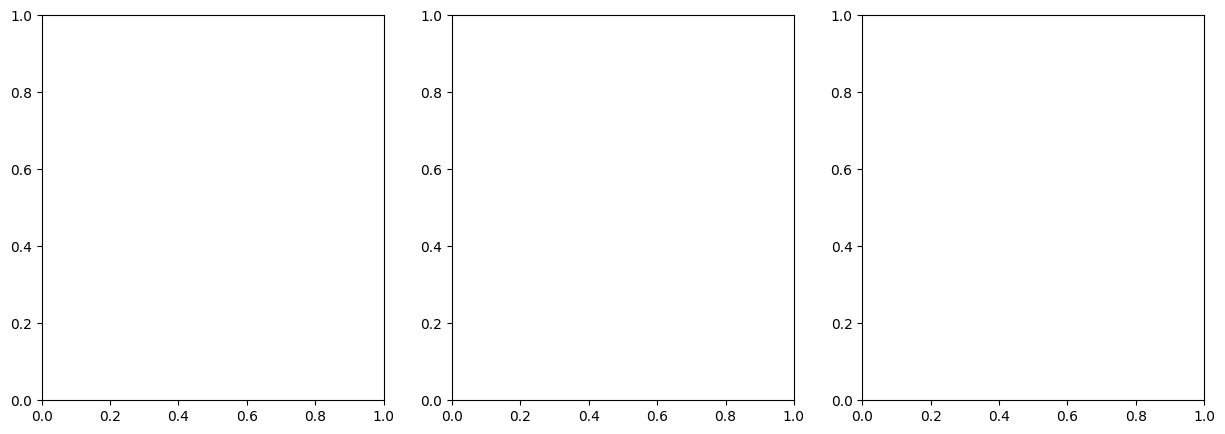

In [27]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = BeefyPolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
landed = []

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]
    landed += [observations[-1, -2:].sum() == 2]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')
        ax2.set_title("Steps per episode")

        # and the number of times we landed
        ax3.set_title("Landed")
        if len(landed) > 30:
            smoothed = [np.mean(landed[i:i+30]) for i in range(len(landed) - 30)]
            ax3.plot(smoothed, color='green')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

Okay, so we're getting this bug: `RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [128, 4]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).` I have a sense that this is caused by our `update` method.

Yep, it's because we run `model.optimizer.step()` many times in a row. We need to do it only once, aka not in the for loop.

In [40]:
def batch_update(model, log_probs, rewards, alpha=.01, gamma=.99, step=True):
    G = discount_rewards(rewards, gamma)

    # can i reorder this so it still works? technically the updates don't have to be done in any order, 
    # so i don't need to use a for loop to iterate over t, i can try to run it in parallel.

    model.optimizer.zero_grad() # reset the gradients

    grads = []
    for t in range(len(G)):
        log_prob = log_probs[t]
        g = G[t]

        log_prob.backward() # compute the gradients of log pi(A_t, S_t, theta) at each timestep
        
        grad_t = {}
        i = 0
        for param in model.parameters():
            if param.grad is not None:
                grad_t[i] = -1. * alpha * gamma**t * g * param.grad # scale the gradients by the reward
            i += 1
        grads += [grad_t]

    # sum all of the grads
    total_grads = {k: sum(d[k] for d in grads) for k in list(grads[0].keys())}

    i = 0
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data = total_grads[i]
        i += 1
    
    if step:
        model.optimizer.step() # update the weights using the gradients
    
    return total_grads

### Testing `batch_update`

There's no practical way in pytorch to ensure the weights get initialized to the same random value every time, but we can store the weights and reload them whenever we test other models.

Let me explain what's going on here. We need to be able to ensure that the gradients that pass when we use the `update` function are the same as the ones when we use the `batch_update` function. To do this, we initialize two models with the same weights, run them through the same episode with the same initial conditions, and we *don't* update the params using `model.optimizer.step()`, but instead just look at what the changes would be.

We're making serious use of the `random.seed` stuff, and we need to to ensure that when we run the model, we get the same results each time, so that if we use the `batch_update` instead of `update`, we can be sure that the only change we introduced is the batching. See how we can run the cell below many times and we always get the same result? That's what we need.

In [53]:
import copy

test_model = PolicyNetwork(env.observation_space.shape[0], (env.action_space.n - env.action_space.start), seed=SEED)
control_model = copy.deepcopy(test_model)

c_rewards, c_log_probs, c_actions, c_observations = run_episode(control_model, seed=1)
c_delta = update(control_model, c_log_probs, c_rewards, step=False)

t_rewards, t_log_probs, t_actions, t_observations = run_episode(test_model, seed=1)
t_delta = update(test_model, t_log_probs, t_rewards, step=False)

print(t_delta)

for key in t_delta:
    assert torch.allclose(c_delta[key], t_delta[key])

del test_model, control_model, c_rewards, c_log_probs, c_actions, c_observations, c_delta, t_rewards, t_log_probs, t_actions, t_observations, t_delta

{0: tensor([[-0.0155, -0.0395,  0.1337, -0.1899, -0.1623, -0.3413, -0.1538,  0.1127],
        [ 0.2858, -0.3486, -0.1272,  0.2224, -0.1912,  0.2387,  0.0143, -0.3324],
        [ 0.0598, -0.2119,  0.0687, -0.3168,  0.3322, -0.1508,  0.2261, -0.2224],
        [-0.2963,  0.1391,  0.2126, -0.0032, -0.2990, -0.0970, -0.2450,  0.1002]])}
{0: tensor([[-0.0155, -0.0395,  0.1337, -0.1899, -0.1623, -0.3413, -0.1538,  0.1127],
        [ 0.2858, -0.3486, -0.1272,  0.2224, -0.1912,  0.2387,  0.0143, -0.3324],
        [ 0.0598, -0.2119,  0.0687, -0.3168,  0.3322, -0.1508,  0.2261, -0.2224],
        [-0.2963,  0.1391,  0.2126, -0.0032, -0.2990, -0.0970, -0.2450,  0.1002]])}
{0: tensor([[-0.0155, -0.0395,  0.1337, -0.1899, -0.1623, -0.3413, -0.1538,  0.1127],
        [ 0.2858, -0.3486, -0.1272,  0.2224, -0.1912,  0.2387,  0.0143, -0.3324],
        [ 0.0598, -0.2119,  0.0687, -0.3168,  0.3322, -0.1508,  0.2261, -0.2224],
        [-0.2963,  0.1391,  0.2126, -0.0032, -0.2990, -0.0970, -0.2450,  0.1002]])

In [57]:
import copy

test_model = PolicyNetwork(env.observation_space.shape[0], (env.action_space.n - env.action_space.start), seed=SEED)
control_model = copy.deepcopy(test_model)

c_rewards, c_log_probs, c_actions, c_observations = run_episode(control_model, seed=1)
c_delta = update(control_model, c_log_probs, c_rewards, step=False)

t_rewards, t_log_probs, t_actions, t_observations = run_episode(test_model, seed=1)
t_delta = batch_update(test_model, t_log_probs, t_rewards, step=False)

for key in t_delta:
    # assert torch.allclose(c_delta[key], t_delta[key])
    print("control", c_delta[key])
    print("test", t_delta[key])

[tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0.]), tensor([ 0.0435, -1.3930,  0.3855,  0.0666, -0.2131, -0.5435,  0.0000,  0.0000]), tensor([ 0.0902, -2.7669,  0.7767,  0.1596, -0.4529, -1.1234,  0.0000,  0.0000]), tensor([ 0.1399, -4.1207,  1.1723,  0.2782, -0.7206, -1.7341,  0.0000,  0.0000]), tensor([ 0.1928, -5.4538,  1.5707,  0.4223, -1.0174, -2.3704,  0.0000,  0.0000]), tensor([ 0.2488, -6.7645,  1.9709,  0.5918, -1.3443, -3.0305,  0.0000,  0.0000]), tensor([ 0.3078, -8.0505,  2.3727,  0.7859,